# FBSDE

Ji, Shaolin, Shige Peng, Ying Peng, and Xichuan Zhang. “Three Algorithms for Solving High-Dimensional Fully-Coupled FBSDEs through Deep Learning.” ArXiv:1907.05327 [Cs, Math], February 2, 2020. http://arxiv.org/abs/1907.05327.

In [3]:
import os
from makers.gpu_utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = str(pick_gpu_lowest_memory())

In [4]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Reshape, concatenate, Layer
from keras import Model, initializers
from keras.callbacks import ModelCheckpoint
from keras.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from keras.metrics import mse
from keras.optimizers import Adam

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


# Inputs

In [6]:
# numerical parameters
n_feeds = 18
n_paths = 2 ** 18
n_timesteps = 4
T = 1.

In [7]:
# learning parameters
batch_size = 128
epochs = 1000
learning_rate = 1e-6

In [8]:
# model parameters
nu = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
eta = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
zeta = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
epsilon = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
lp = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
lm = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
k = 1.
phi = 1e-2
psi = 1e-2

In [9]:
# avoid loops, spell out coefficients explicitly
def b(t, x, y, z, r):
    
    return [
        
        x[1],
        -eta[0] * x[1],
        lm[0] * tf.exp(-k * tf.maximum(0., 1. / k - (y[2] / y[54] - x[0]))) - lp[0] * tf.exp(-k * tf.maximum(0., 1. / k + (y[2] / y[54] - x[0]))),
        
        x[4],
        -eta[1] * x[4],
        lm[1] * tf.exp(-k * tf.maximum(0., 1. / k - (y[5] / y[54] - x[3]))) - lp[1] * tf.exp(-k * tf.maximum(0., 1. / k + (y[5] / y[54] - x[3]))),
        
        x[7],
        -eta[2] * x[7],
        lm[2] * tf.exp(-k * tf.maximum(0., 1. / k - (y[8] / y[54] - x[6]))) - lp[2] * tf.exp(-k * tf.maximum(0., 1. / k + (y[8] / y[54] - x[6]))),
        
        x[10],
        -eta[3] * x[10],
        lm[3] * tf.exp(-k * tf.maximum(0., 1. / k - (y[11] / y[54] - x[9]))) - lp[3] * tf.exp(-k * tf.maximum(0., 1. / k + (y[11] / y[54] - x[9]))),
        
        x[13],
        -eta[4] * x[13],
        lm[4] * tf.exp(-k * tf.maximum(0., 1. / k - (y[14] / y[54] - x[12]))) - lp[4] * tf.exp(-k * tf.maximum(0., 1. / k + (y[14] / y[54] - x[12]))),
        
        x[16],
        -eta[5] * x[16],
        lm[5] * tf.exp(-k * tf.maximum(0., 1. / k - (y[17] / y[54] - x[15]))) - lp[5] * tf.exp(-k * tf.maximum(0., 1. / k + (y[17] / y[54] - x[15]))),
        
        x[19],
        -eta[6] * x[19],
        lm[6] * tf.exp(-k * tf.maximum(0., 1. / k - (y[20] / y[54] - x[18]))) - lp[6] * tf.exp(-k * tf.maximum(0., 1. / k + (y[20] / y[54] - x[18]))),
        
        x[22],
        -eta[7] * x[22],
        lm[7] * tf.exp(-k * tf.maximum(0., 1. / k - (y[23] / y[54] - x[21]))) - lp[7] * tf.exp(-k * tf.maximum(0., 1. / k + (y[23] / y[54] - x[21]))),
        
        x[25],
        -eta[8] * x[25],
        lm[8] * tf.exp(-k * tf.maximum(0., 1. / k - (y[26] / y[54] - x[24]))) - lp[8] * tf.exp(-k * tf.maximum(0., 1. / k + (y[26] / y[54] - x[24]))),
        
        x[28],
        -eta[9] * x[28],
        lm[9] * tf.exp(-k * tf.maximum(0., 1. / k - (y[29] / y[54] - x[27]))) - lp[9] * tf.exp(-k * tf.maximum(0., 1. / k + (y[29] / y[54] - x[27]))),
        
        x[31],
        -eta[10] * x[31],
        lm[10] * tf.exp(-k * tf.maximum(0., 1. / k - (y[32] / y[54] - x[30]))) - lp[10] * tf.exp(-k * tf.maximum(0., 1. / k + (y[32] / y[54] - x[30]))),
        
        x[34],
        -eta[11] * x[34],
        lm[11] * tf.exp(-k * tf.maximum(0., 1. / k - (y[35] / y[54] - x[33]))) - lp[11] * tf.exp(-k * tf.maximum(0., 1. / k + (y[35] / y[54] - x[33]))),
        
        x[37],
        -eta[12] * x[37],
        lm[12] * tf.exp(-k * tf.maximum(0., 1. / k - (y[38] / y[54] - x[36]))) - lp[12] * tf.exp(-k * tf.maximum(0., 1. / k + (y[38] / y[54] - x[36]))),
        
        x[40],
        -eta[13] * x[40],
        lm[13] * tf.exp(-k * tf.maximum(0., 1. / k - (y[41] / y[54] - x[39]))) - lp[13] * tf.exp(-k * tf.maximum(0., 1. / k + (y[41] / y[54] - x[39]))),
        
        x[43],
        -eta[14] * x[43],
        lm[14] * tf.exp(-k * tf.maximum(0., 1. / k - (y[44] / y[54] - x[42]))) - lp[14] * tf.exp(-k * tf.maximum(0., 1. / k + (y[44] / y[54] - x[42]))),
        
        x[46],
        -eta[15] * x[46],
        lm[15] * tf.exp(-k * tf.maximum(0., 1. / k - (y[47] / y[54] - x[45]))) - lp[15] * tf.exp(-k * tf.maximum(0., 1. / k + (y[47] / y[54] - x[45]))),
        
        x[49],
        -eta[16] * x[49],
        lm[16] * tf.exp(-k * tf.maximum(0., 1. / k - (y[50] / y[54] - x[48]))) - lp[16] * tf.exp(-k * tf.maximum(0., 1. / k + (y[50] / y[54] - x[48]))),
        
        x[52],
        -eta[17] * x[52],
        lm[17] * tf.exp(-k * tf.maximum(0., 1. / k - (y[53] / y[54] - x[51]))) - lp[17] * tf.exp(-k * tf.maximum(0., 1. / k + (y[53] / y[54] - x[51]))),
        
        # last cash component
        lp[0] * (x[0] + tf.maximum(0., 1. / k + (y[2] / y[54] - x[0]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[2] / y[54] - x[0]))) - lm[0] * (x[0] - tf.maximum(0., 1. / k - (y[2] / y[54] - x[0]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[2] / y[54] - x[0])))+\
        lp[1] * (x[3] + tf.maximum(0., 1. / k + (y[5] / y[54] - x[3]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[5] / y[54] - x[3]))) - lm[1] * (x[3] - tf.maximum(0., 1. / k - (y[5] / y[54] - x[3]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[5] / y[54] - x[3])))+\
        lp[2] * (x[6] + tf.maximum(0., 1. / k + (y[8] / y[54] - x[6]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[8] / y[54] - x[6]))) - lm[2] * (x[6] - tf.maximum(0., 1. / k - (y[8] / y[54] - x[6]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[8] / y[54] - x[6])))+\
        lp[3] * (x[9] + tf.maximum(0., 1. / k + (y[11] / y[54] - x[9]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[11] / y[54] - x[9]))) - lm[3] * (x[9] - tf.maximum(0., 1. / k - (y[11] / y[54] - x[9]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[11] / y[54] - x[9])))+\
        lp[4] * (x[12] + tf.maximum(0., 1. / k + (y[14] / y[54] - x[12]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[14] / y[54] - x[12]))) - lm[4] * (x[12] - tf.maximum(0., 1. / k - (y[14] / y[54] - x[12]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[14] / y[54] - x[12])))+\
        lp[5] * (x[15] + tf.maximum(0., 1. / k + (y[17] / y[54] - x[15]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[17] / y[54] - x[15]))) - lm[5] * (x[15] - tf.maximum(0., 1. / k - (y[17] / y[54] - x[15]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[17] / y[54] - x[15])))+\
        lp[6] * (x[18] + tf.maximum(0., 1. / k + (y[20] / y[54] - x[18]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[20] / y[54] - x[18]))) - lm[6] * (x[18] - tf.maximum(0., 1. / k - (y[20] / y[54] - x[18]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[20] / y[54] - x[18])))+\
        lp[7] * (x[21] + tf.maximum(0., 1. / k + (y[23] / y[54] - x[21]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[23] / y[54] - x[21]))) - lm[7] * (x[21] - tf.maximum(0., 1. / k - (y[23] / y[54] - x[21]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[23] / y[54] - x[21])))+\
        lp[8] * (x[24] + tf.maximum(0., 1. / k + (y[26] / y[54] - x[24]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[26] / y[54] - x[24]))) - lm[8] * (x[24] - tf.maximum(0., 1. / k - (y[26] / y[54] - x[24]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[26] / y[54] - x[24])))+\
        lp[9] * (x[27] + tf.maximum(0., 1. / k + (y[29] / y[54] - x[27]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[29] / y[54] - x[27]))) - lm[9] * (x[27] - tf.maximum(0., 1. / k - (y[29] / y[54] - x[27]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[29] / y[54] - x[27])))+\
        lp[10] * (x[30] + tf.maximum(0., 1. / k + (y[32] / y[54] - x[30]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[32] / y[54] - x[30]))) - lm[10] * (x[30] - tf.maximum(0., 1. / k - (y[32] / y[54] - x[30]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[32] / y[54] - x[30])))+\
        lp[11] * (x[33] + tf.maximum(0., 1. / k + (y[35] / y[54] - x[33]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[35] / y[54] - x[33]))) - lm[11] * (x[33] - tf.maximum(0., 1. / k - (y[35] / y[54] - x[33]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[35] / y[54] - x[33])))+\
        lp[12] * (x[36] + tf.maximum(0., 1. / k + (y[38] / y[54] - x[36]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[38] / y[54] - x[36]))) - lm[12] * (x[36] - tf.maximum(0., 1. / k - (y[38] / y[54] - x[36]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[38] / y[54] - x[36])))+\
        lp[13] * (x[39] + tf.maximum(0., 1. / k + (y[41] / y[54] - x[39]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[41] / y[54] - x[39]))) - lm[13] * (x[39] - tf.maximum(0., 1. / k - (y[41] / y[54] - x[39]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[41] / y[54] - x[39])))+\
        lp[14] * (x[42] + tf.maximum(0., 1. / k + (y[44] / y[54] - x[42]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[44] / y[54] - x[42]))) - lm[14] * (x[42] - tf.maximum(0., 1. / k - (y[44] / y[54] - x[42]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[44] / y[54] - x[42])))+\
        lp[15] * (x[45] + tf.maximum(0., 1. / k + (y[47] / y[54] - x[45]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[47] / y[54] - x[45]))) - lm[15] * (x[45] - tf.maximum(0., 1. / k - (y[47] / y[54] - x[45]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[47] / y[54] - x[45])))+\
        lp[16] * (x[48] + tf.maximum(0., 1. / k + (y[50] / y[54] - x[48]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[50] / y[54] - x[48]))) - lm[16] * (x[48] - tf.maximum(0., 1. / k - (y[50] / y[54] - x[48]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[50] / y[54] - x[48])))+\
        lp[17] * (x[51] + tf.maximum(0., 1. / k + (y[53] / y[54] - x[51]))) * tf.exp(-k * tf.maximum(0., 1. / k + (y[53] / y[54] - x[51]))) - lm[17] * (x[51] - tf.maximum(0., 1. / k - (y[53] / y[54] - x[51]))) * tf.exp(-k * tf.maximum(0., 1. / k - (y[53] / y[54] - x[51])))
        
    ]

def s(t, x, y, z, r):
    return [
        [nu[0], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., zeta[0], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., nu[1], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., zeta[1], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., nu[2], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., zeta[2], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., nu[3], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., zeta[3], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., nu[4], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[4], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[5], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[5], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[6], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[6], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[7], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[7], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[8], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[8], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[9], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[9], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[10], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[10], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[11], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[11], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[12], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[12], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[13], 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[13], 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[14], 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[14], 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[15], 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[15], 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[16], 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[16], 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nu[17], 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., zeta[17]],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    ]

# - dH_dx
def f(t, x, y, z, r):
    
    return [
        -(y[54] * lp[0] * tf.exp(-k * tf.maximum(0., 1. / k + (y[2] / y[54] - x[0]))) - y[54] * lm[0] * tf.exp(-k * tf.maximum(0., 1. / k - (y[2] / y[54] - x[0])))),
        -(y[0] - eta[0] * y[1]),
        -(-2. * phi * x[2]),
        -(y[54] * lp[1] * tf.exp(-k * tf.maximum(0., 1. / k + (y[5] / y[54] - x[3]))) - y[54] * lm[1] * tf.exp(-k * tf.maximum(0., 1. / k - (y[5] / y[54] - x[3])))),
        -(y[3] - eta[1] * y[4]),
        -(-2. * phi * x[5]),
        -(y[54] * lp[2] * tf.exp(-k * tf.maximum(0., 1. / k + (y[8] / y[54] - x[6]))) - y[54] * lm[2] * tf.exp(-k * tf.maximum(0., 1. / k - (y[8] / y[54] - x[6])))),
        -(y[6] - eta[2] * y[7]),
        -(-2. * phi * x[8]),
        -(y[54] * lp[3] * tf.exp(-k * tf.maximum(0., 1. / k + (y[11] / y[54] - x[9]))) - y[54] * lm[3] * tf.exp(-k * tf.maximum(0., 1. / k - (y[11] / y[54] - x[9])))),
        -(y[9] - eta[3] * y[10]),
        -(-2. * phi * x[11]),
        -(y[54] * lp[4] * tf.exp(-k * tf.maximum(0., 1. / k + (y[14] / y[54] - x[12]))) - y[54] * lm[4] * tf.exp(-k * tf.maximum(0., 1. / k - (y[14] / y[54] - x[12])))),
        -(y[12] - eta[4] * y[13]),
        -(-2. * phi * x[14]),
        -(y[54] * lp[5] * tf.exp(-k * tf.maximum(0., 1. / k + (y[17] / y[54] - x[15]))) - y[54] * lm[5] * tf.exp(-k * tf.maximum(0., 1. / k - (y[17] / y[54] - x[15])))),
        -(y[15] - eta[5] * y[16]),
        -(-2. * phi * x[17]),
        -(y[54] * lp[6] * tf.exp(-k * tf.maximum(0., 1. / k + (y[20] / y[54] - x[18]))) - y[54] * lm[6] * tf.exp(-k * tf.maximum(0., 1. / k - (y[20] / y[54] - x[18])))),
        -(y[18] - eta[6] * y[19]),
        -(-2. * phi * x[20]),
        -(y[54] * lp[7] * tf.exp(-k * tf.maximum(0., 1. / k + (y[23] / y[54] - x[21]))) - y[54] * lm[7] * tf.exp(-k * tf.maximum(0., 1. / k - (y[23] / y[54] - x[21])))),
        -(y[21] - eta[7] * y[22]),
        -(-2. * phi * x[23]),
        -(y[54] * lp[8] * tf.exp(-k * tf.maximum(0., 1. / k + (y[26] / y[54] - x[24]))) - y[54] * lm[8] * tf.exp(-k * tf.maximum(0., 1. / k - (y[26] / y[54] - x[24])))),
        -(y[24] - eta[8] * y[25]),
        -(-2. * phi * x[26]),
        -(y[54] * lp[9] * tf.exp(-k * tf.maximum(0., 1. / k + (y[29] / y[54] - x[27]))) - y[54] * lm[9] * tf.exp(-k * tf.maximum(0., 1. / k - (y[29] / y[54] - x[27])))),
        -(y[27] - eta[9] * y[28]),
        -(-2. * phi * x[29]),
        -(y[54] * lp[10] * tf.exp(-k * tf.maximum(0., 1. / k + (y[32] / y[54] - x[30]))) - y[54] * lm[10] * tf.exp(-k * tf.maximum(0., 1. / k - (y[32] / y[54] - x[30])))),
        -(y[30] - eta[10] * y[31]),
        -(-2. * phi * x[32]),
        -(y[54] * lp[11] * tf.exp(-k * tf.maximum(0., 1. / k + (y[35] / y[54] - x[33]))) - y[54] * lm[11] * tf.exp(-k * tf.maximum(0., 1. / k - (y[35] / y[54] - x[33])))),
        -(y[33] - eta[11] * y[34]),
        -(-2. * phi * x[35]),
        -(y[54] * lp[12] * tf.exp(-k * tf.maximum(0., 1. / k + (y[38] / y[54] - x[36]))) - y[54] * lm[12] * tf.exp(-k * tf.maximum(0., 1. / k - (y[38] / y[54] - x[36])))),
        -(y[36] - eta[12] * y[37]),
        -(-2. * phi * x[38]),
        -(y[54] * lp[13] * tf.exp(-k * tf.maximum(0., 1. / k + (y[41] / y[54] - x[39]))) - y[54] * lm[13] * tf.exp(-k * tf.maximum(0., 1. / k - (y[41] / y[54] - x[39])))),
        -(y[39] - eta[13] * y[40]),
        -(-2. * phi * x[41]),
        -(y[54] * lp[14] * tf.exp(-k * tf.maximum(0., 1. / k + (y[44] / y[54] - x[42]))) - y[54] * lm[14] * tf.exp(-k * tf.maximum(0., 1. / k - (y[44] / y[54] - x[42])))),
        -(y[42] - eta[14] * y[43]),
        -(-2. * phi * x[44]),
        -(y[54] * lp[15] * tf.exp(-k * tf.maximum(0., 1. / k + (y[47] / y[54] - x[45]))) - y[54] * lm[15] * tf.exp(-k * tf.maximum(0., 1. / k - (y[47] / y[54] - x[45])))),
        -(y[45] - eta[15] * y[46]),
        -(-2. * phi * x[47]),
        -(y[54] * lp[16] * tf.exp(-k * tf.maximum(0., 1. / k + (y[50] / y[54] - x[48]))) - y[54] * lm[16] * tf.exp(-k * tf.maximum(0., 1. / k - (y[50] / y[54] - x[48])))),
        -(y[48] - eta[16] * y[49]),
        -(-2. * phi * x[50]),
        -(y[54] * lp[17] * tf.exp(-k * tf.maximum(0., 1. / k + (y[53] / y[54] - x[51]))) - y[54] * lm[17] * tf.exp(-k * tf.maximum(0., 1. / k - (y[53] / y[54] - x[51])))),
        -(y[51] - eta[17] * y[52]),
        -(-2. * phi * x[53]),
        -(0.),
    ]

def v(t, x, y, z, r):
    return [
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [epsilon[0], -epsilon[0], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., epsilon[1], -epsilon[1], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., epsilon[2], -epsilon[2], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., epsilon[3], -epsilon[3], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., epsilon[4], -epsilon[4], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[5], -epsilon[5], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[6], -epsilon[6], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[7], -epsilon[7], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[8], -epsilon[8], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[9], -epsilon[9], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[10], -epsilon[10], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[11], -epsilon[11], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[12], -epsilon[12], 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[13], -epsilon[13], 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[14], -epsilon[14], 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[15], -epsilon[15], 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[16], -epsilon[16], 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., epsilon[17], -epsilon[17]],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    ]

# dg_dx
def g(x):
    return [
        x[2],
        0.,
        x[0] - 2 * psi * x[2],
        x[5],
        0.,
        x[3] - 2 * psi * x[5],
        x[8],
        0.,
        x[6] - 2 * psi * x[8],
        x[11],
        0.,
        x[9] - 2 * psi * x[11],
        x[14],
        0.,
        x[12] - 2 * psi * x[14],
        x[17],
        0.,
        x[15] - 2 * psi * x[17],
        x[20],
        0.,
        x[18] - 2 * psi * x[20],
        x[23],
        0.,
        x[21] - 2 * psi * x[23],
        x[26],
        0.,
        x[24] - 2 * psi * x[26],
        x[29],
        0.,
        x[27] - 2 * psi * x[29],
        x[32],
        0.,
        x[30] - 2 * psi * x[32],
        x[35],
        0.,
        x[33] - 2 * psi * x[35],
        x[38],
        0.,
        x[36] - 2 * psi * x[38],
        x[41],
        0.,
        x[39] - 2 * psi * x[41],
        x[44],
        0.,
        x[42] - 2 * psi * x[44],
        x[47],
        0.,
        x[45] - 2 * psi * x[47],
        x[50],
        0.,
        x[48] - 2 * psi * x[50],
        x[53],
        0.,
        x[51] - 2 * psi * x[53],
        1.,
    ]

# Automatic parameters

In [10]:
# for each feed midprice, alpha, inventory + one cash process
n_dimensions = n_feeds * 3 + 1

# midprice and alpha
n_diffusion_factors = 2 * n_feeds

# buy and sell MO
n_jump_factors = 2 * n_feeds

# timestep
dt = T / n_timesteps

# Initial value layer

In [11]:
class InitialValue(Layer):
    
    def __init__(self, y0, **kwargs):
        super().__init__(**kwargs)
        self.y0 = y0
    
    def call(self, inputs):
        return self.y0

# Model

In [12]:
def dX(t, x, y, z, r, dW, dN):
    
    def drift(arg):
        x, y, z, r = arg
        return tf.math.multiply(b(t, x, y, z, r), dt)
    a0 = tf.vectorized_map(drift, (x, y, z, r))
        
    def noise(arg):
        x, y, z, r, dW = arg
        return tf.tensordot(s(t, x, y, z ,r), dW, [[1], [0]])
    a1 = tf.vectorized_map(noise, (x, y, z, r, dW))

    def jump(arg):
        x, y, z, r, dN = arg
        return tf.tensordot(v(t, x, y, z ,r), dN, [[1], [0]])
    a2 = tf.vectorized_map(jump, (x, y, z, r, dN))
    
    return a0 + a1 + a2

def dY(t, x, y, z, r, dW, dN):
    
    def drift(arg):
        x, y, z, r = arg
        return tf.math.multiply(f(t, x, y, z, r), dt)
    a0 = tf.vectorized_map(drift, (x, y, z, r))

    def noise(arg):
        x, y, z, r, dW = arg
        return tf.tensordot(z, dW, [[1], [0]])
    a1 = tf.vectorized_map(noise, (x, y, z, r, dW))
    
    def jump(arg):
        x, y, z, r, dN = arg
        return tf.tensordot(r, dN, [[1], [0]])
    a2 = tf.vectorized_map(jump, (x, y, z, r, dN))
    
    return a0 + a1 + a2

In [13]:
paths = []

n_hidden_units = n_dimensions + n_diffusion_factors + n_jump_factors + 10

inputs_dW = Input(shape=(n_timesteps, n_diffusion_factors))
inputs_dN = Input(shape=(n_timesteps, n_jump_factors))

x0 = tf.Variable([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], trainable=False)
y0 = tf.Variable([g(x0[0])], trainable=True)

x = InitialValue(x0, name='x_0')(inputs_dW)
y = InitialValue(y0, name='y_0')(inputs_dW)

z = concatenate([x, y])
z = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='z1_0')(z)
z = Dense(n_dimensions * n_diffusion_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='z2_0')(z)
z = Reshape((n_dimensions, n_diffusion_factors), name='zr_0')(z)

r = concatenate([x, y])
r = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='r1_0')(r)
r = Dense(n_dimensions * n_jump_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='r2_0')(r)
r = Reshape((n_dimensions, n_jump_factors), name='rr_0')(r)

paths += [[x, y, z, r]]

# pre-compile lambda layers

@tf.function
def hx(args):
    i, x, y, z, r, dW, dN = args
    return x + dX(i * dt, x, y, z, r, dW, dN)

@tf.function
def hy(args):
    i, x, y, z, r, dW, dN = args
    return y + dY(i * dt, x, y, z, r, dW, dN)

for i in range(n_timesteps):
    
    step = InitialValue(tf.Variable(i, dtype=tf.float32, trainable=False))(inputs_dW)
    
    dW = Lambda(lambda x: x[0][:, tf.cast(x[1], tf.int32)])([inputs_dW, step])
    dN = Lambda(lambda x: x[0][:, tf.cast(x[1], tf.int32)])([inputs_dN, step])
    
    x, y = (
        Lambda(hx, name=f'x_{i+1}')([step, x, y, z, r, dW, dN]),
        Lambda(hy, name=f'y_{i+1}')([step, x, y, z, r, dW, dN]),
    )
    
    # we don't train z for the last time step; keep for consistency
    z = concatenate([x, y])
    z = Dense(n_hidden_units, activation='relu', name=f'z1_{i+1}')(z)
    z = Dense(n_dimensions * n_diffusion_factors, activation='relu', name=f'z2_{i+1}')(z)
    z = Reshape((n_dimensions, n_diffusion_factors), name=f'zr_{i+1}')(z)
    
    # we don't train r for the last time step; keep for consistency
    r = concatenate([x, y])
    r = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name=f'r1_{i+1}')(r)
    r = Dense(n_dimensions * n_jump_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name=f'r2_{i+1}')(r)
    r = Reshape((n_dimensions, n_jump_factors), name=f'rr_{i+1}')(r)

    paths += [[x, y, z, r]]
    
outputs_loss = Lambda(lambda r: r[1] - tf.transpose(tf.vectorized_map(g, r[0])))([x, y])
outputs_paths = tf.stack(
    [tf.stack([p[0] for p in paths[1:]], axis=1), tf.stack([p[1] for p in paths[1:]], axis=1)] + 
    [tf.stack([p[2][:, :, i] for p in paths[1:]], axis=1) for i in range(n_diffusion_factors)] +
    [tf.stack([p[3][:, :, i] for p in paths[1:]], axis=1) for i in range(n_jump_factors)], axis=2)

adam = Adam(learning_rate=learning_rate)

model_loss = Model([inputs_dW, inputs_dN], outputs_loss)
model_loss.compile(loss='mse', optimizer=adam)

# (n_sample, n_timestep, x/y/z_k, n_dimension)
# skips the first time step
model_paths = Model([inputs_dW, inputs_dN], outputs_paths)


In [14]:
model_loss.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 36)]      0                                            
__________________________________________________________________________________________________
x_0 (InitialValue)              (1, 55)              55          input_1[0][0]                    
__________________________________________________________________________________________________
y_0 (InitialValue)              (1, 55)              55          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (1, 110)             0           x_0[0][0]                        
                                                                 y_0[0][0]                    

# Transfer weights (if needed)

In [ ]:
# try transfer learning from another starting point

model_loss.get_layer('y_0').set_weights(m_large.get_layer('y_0').get_weights())

for i in range(n_timesteps):
    model_loss.get_layer(f'z1_{i}').set_weights(m_large.get_layer(f'z1_{i}').get_weights())
    model_loss.get_layer(f'z2_{i}').set_weights(m_large.get_layer(f'z2_{i}').get_weights())

In [ ]:
# transfer learning from cruder discretization

model_loss.get_layer('y_0').set_weights(m_small.get_layer('y_0').get_weights())

n_small = 4

for i in range(n_small):
    for j in range(n_timesteps // n_small):
        model_loss.get_layer(f'z1_{n_timesteps // n_small * i}').set_weights(m_small.get_layer(f'z1_{i}').get_weights())
        model_loss.get_layer(f'z2_{n_timesteps // n_small * i}').set_weights(m_small.get_layer(f'z2_{i}').get_weights())
        model_loss.get_layer(f'z1_{n_timesteps // n_small * i + j}').set_weights(m_small.get_layer(f'z1_{i}').get_weights())
        model_loss.get_layer(f'z2_{n_timesteps // n_small * i + j}').set_weights(m_small.get_layer(f'z2_{i}').get_weights())

# Training

In [15]:
dW = tf.sqrt(dt) * tf.random.normal((n_paths, n_timesteps, n_diffusion_factors))
dN = tf.random.poisson((n_paths, n_timesteps), tf.constant(dt * np.array([lp, lm]).transpose().reshape(-1)))
target = tf.zeros((n_paths, n_dimensions))

In [ ]:
# check for exploding gradients before training

with tf.GradientTape() as tape:
    loss = mse(model_loss([dW, dN]), target)

# bias of the last dense layer
variables = model_loss.variables[-1]
tape.gradient(loss, variables)

The following Variables were used a Lambda layer's call (x_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 55) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (y_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 55) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
log_dir = "_logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_callback = ModelCheckpoint('_models/weights{epoch:04d}.h5', save_weights_only=True, overwrite=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_loss.save_weights('_models/weights0000.h5')
history = model_loss.fit([dW, dN], target, batch_size=128, epochs=1000, callbacks=[checkpoint_callback, tensorboard_callback])


In [18]:
# validate

dW_test = tf.sqrt(dt) * tf.random.normal((n_paths//8, n_timesteps, n_diffusion_factors))
dN_test = tf.random.poisson((n_paths//8, n_timesteps), tf.constant(dt * np.array([lp, lm]).transpose().reshape(-1)))
target_test = tf.zeros((n_paths//8, n_dimensions))

model_loss.evaluate([dW_test, dN_test], target_test)

1024/1024 [==============================] - 84s 13ms/step - loss: 0.0011


0.0010734807001426816

# Display paths and loss

In [ ]:
# load bad model
model_loss.load_weights('_models/weights0011.h5')

In [55]:
loss = model_loss([dW, dN]).numpy()
loss

array([[-4.21302719e-03, -1.83777374e-04,  7.68974721e-02, ...,
        -1.08535380e-04, -3.65010686e-02, -1.43885612e-04],
       [ 3.12728644e-03, -1.86214020e-04,  1.65139437e-02, ...,
        -1.07569365e-04,  9.47822630e-02, -1.43885612e-04],
       [-1.13846944e-03, -1.84155477e-04,  3.47495675e-02, ...,
        -1.07487824e-04, -5.74785471e-03, -1.43885612e-04],
       ...,
       [-4.19508014e-03, -1.82968608e-04,  9.62089002e-03, ...,
        -1.07971777e-04, -5.63402846e-03, -1.43885612e-04],
       [-1.20397564e-02, -1.82203512e-04,  1.12469167e-01, ...,
        -1.08954977e-04, -2.62902267e-02, -1.43885612e-04],
       [-3.71439802e-03, -1.83611395e-04,  4.11325842e-02, ...,
        -1.07773740e-04,  1.11734495e-02, -1.43885612e-04]], dtype=float32)

In [59]:
paths = model_paths([dW, dN]).numpy()

In [60]:
def output(n0):
    x = tf.transpose(paths[n0, :, 0, :], (1, 0))
    dp1 = tf.maximum(0., 1./k + (paths[n0, :, 1, 2] / paths[n0, :, 1, 9] - paths[n0, :, 0, 0]))
    dm1 = tf.maximum(0., 1./k - (paths[n0, :, 1, 2] / paths[n0, :, 1, 9] - paths[n0, :, 0, 0]))
    dp2 = tf.maximum(0., 1./k + (paths[n0, :, 1, 5] / paths[n0, :, 1, 9] - paths[n0, :, 0, 3]))
    dm2 = tf.maximum(0., 1./k - (paths[n0, :, 1, 5] / paths[n0, :, 1, 9] - paths[n0, :, 0, 3]))
    dp3 = tf.maximum(0., 1./k + (paths[n0, :, 1, 8] / paths[n0, :, 1, 9] - paths[n0, :, 0, 6]))
    dm3 = tf.maximum(0., 1./k - (paths[n0, :, 1, 8] / paths[n0, :, 1, 9] - paths[n0, :, 0, 6]))
    return tf.concat([
        x,
        tf.expand_dims(dp1, 0),
        tf.expand_dims(dm1, 0),
        tf.expand_dims(dp2, 0),
        tf.expand_dims(dm2, 0),
        tf.expand_dims(dp3, 0),
        tf.expand_dims(dm3, 0),
    ], axis=0)

for i in range(120, 140):
    print(output(i))

tf.Tensor(
[[-3.12879570e-02 -2.40089763e-02  3.05218529e-02  1.10586852e-01
   1.02367669e-01  7.77193382e-02  1.46616668e-01  1.90133542e-01]
 [ 3.92885469e-02  2.61176471e-02  3.00021134e-02  7.64059499e-02
   6.31766990e-02  4.84655388e-02  4.68628518e-02  9.48818773e-03]
 [-2.70983204e-04  3.35657969e-05  1.65806152e-04 -6.56196848e-04
  -1.29865296e-03 -1.78988371e-03 -2.46657897e-03 -3.42780352e-03]
 [-1.69686542e-03 -1.38930380e-02  7.52845630e-02  4.43776697e-02
   6.93124980e-02  9.42039043e-02  1.15953438e-01  1.12285599e-01]
 [ 2.65748110e-02  3.66587006e-02  6.92061782e-02  1.26366660e-01
   1.08490385e-01  1.29401341e-01  1.39311910e-01  4.58929762e-02]
 [-8.92085955e-05  1.33596361e-04  4.14848328e-04  6.46529719e-04
   1.20008644e-03  1.44169200e-03  1.44595746e-03  1.15436409e-03]
 [-5.93542568e-02 -5.07995673e-02 -6.44222647e-03  2.29085647e-02
   2.34140810e-02  1.40835121e-02  4.05812599e-02  1.75533965e-02]
 [ 9.08452924e-03  3.94053683e-02  2.10547019e-02  3.40619

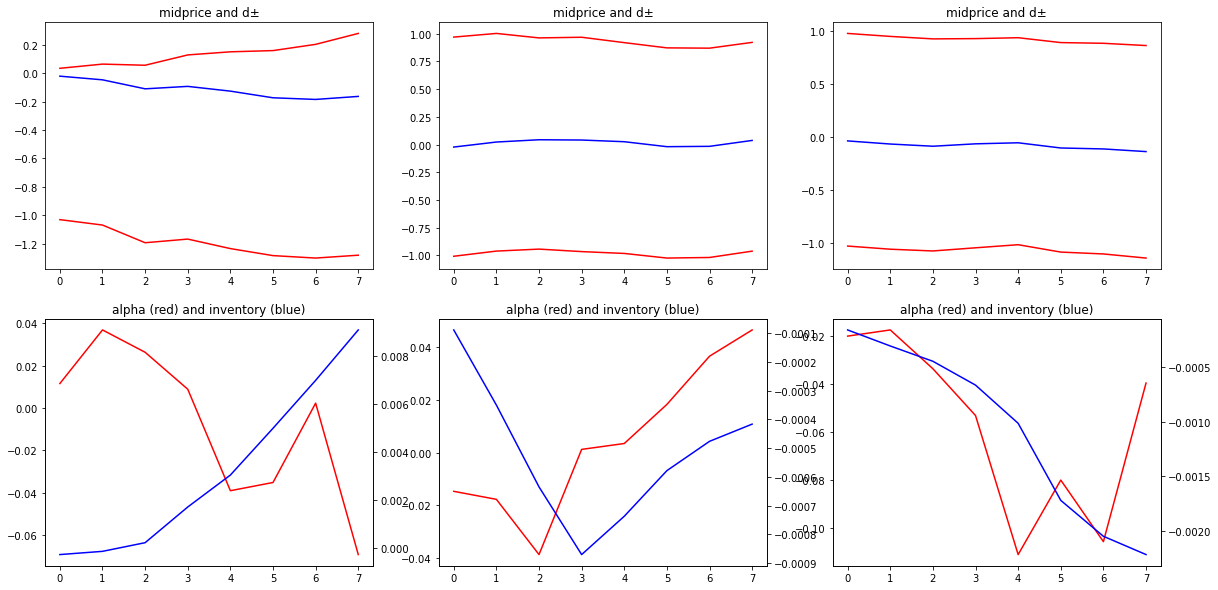

In [61]:
n_feeds = 3
out = output(500).numpy()

fig, ax = plt.subplots(nrows=2, ncols=n_feeds, figsize=(20, 10))

for i in range(n_feeds):

    ax[0][i].set_title('midprice and d±')
    ax[0][i].plot(out[n_feeds*i], c='b')
    ax[0][i].plot(out[n_feeds*i] + out[n_feeds*3+2*i], c='r')
    ax[0][i].plot(out[n_feeds*i] - out[n_feeds*3+2*i+1], c='r')

    ax[1][i].set_title('alpha (red) and inventory (blue)')
    ax[1][i].plot(out[n_feeds*i+1], c='r')
    ax[1][i].twinx().plot(out[n_feeds*i+2], c='b')

    # plt.plot(output(120).numpy().transpose())